In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [3]:
!pip install transformers

     |████████████████████████████████| 573kB 5.9MB/s 
     |████████████████████████████████| 1.0MB 15.1MB/s 
     |████████████████████████████████| 890kB 37.6MB/s 
     |████████████████████████████████| 3.7MB 43.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=29933bd3ab49bd7f898a6104567bb2a7cf6fc6f7163e9b2bae269ba6237ef91f
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sacremoses


In [4]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split

file = "combined_{}.csv"
dfs = []
for i in range(3):
    fp = file.format(i+1)
    read = pd.read_csv(fp)
    read = read[['label', 'clean_text']]
    dfs.append(read)

onion_df = pd.read_csv('onion_clean.csv')[['label', 'clean_text']]
dfs.append(onion_df)

data = pd.concat(dfs)
data.tail()
data.reset_index(inplace=True, drop=True)
print(data.shape)
print(data[data.label == 1].shape[0], "Real")
print(data[data.label == 0].shape[0], "Fake")

data.dropna(inplace=True)
train_data, test_data = train_test_split(data, test_size=0.2)

sentences = train_data.clean_text.values
labels = train_data.label.values

train_data.head(10)

(87686, 2)
44514 Real
43172 Fake


,label,clean_text
64658,1,russia united states agreed set working group ...
73578,0,ralph northam admits engaged pedophilia part m...
75869,0,senate passes bipartisan opioid legislation
75212,0,hardhitting journalism year joint investigatio...
67822,1,fight apple government burst open last week fe...
78142,0,ignorance bliss baby movie old enough drive wo...
17326,1,musicians poets educators baristas people kill...
53068,1,new york times wednesday showcasing obscenitie...
17331,1,republican elected officials donors strategist...
20700,0,home world vive la rvolution marine le pen f...


In [5]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Loading BERT tokenizer...



 Original:  russia united states agreed set working group try mend battered ties wednesday secretary state rex tillerson held lengthy talks moscow president vladimir putin russian foreign minister clear last minute whether putin would grant tillerson audience fact likely seen sign moscow given new administration wants try improve ties sides agree languishing post cold war low joint news conference sergei lavrov russian foreign minister tillerson showed much work though russian used many speaking opportunities lambast washington actions syria said unhelpful foreign interference past tillerson first visit russia current role struck conciliatory stance said ties trust levels low point restated washingtons position syrian president bashar must eventually relinquish power position starkly odds russia low level trust two countries tillerson said worlds two foremost nuclear powers cannot kind relationship lavrov said russia placing hopes assad individual syria toppling syrian government opti

In [6]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512  # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  russia united states agreed set working group try mend battered ties wednesday secretary state rex tillerson held lengthy talks moscow president vladimir putin russian foreign minister clear last minute whether putin would grant tillerson audience fact likely seen sign moscow given new administration wants try improve ties sides agree languishing post cold war low joint news conference sergei lavrov russian foreign minister tillerson showed much work though russian used many speaking opportunities lambast washington actions syria said unhelpful foreign interference past tillerson first visit russia current role struck conciliatory stance said ties trust levels low point restated washingtons position syrian president bashar must eventually relinquish power position starkly odds russia low level trust two countries tillerson said worlds two foremost nuclear powers cannot kind relationship lavrov said russia placing hopes assad individual syria toppling syrian government option

In [7]:
import statistics

print('Avg sentence length: ', statistics.mean([len(sen) for sen in input_ids]))

Avg sentence length:  263.9276084361321


In [8]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  512


In [9]:
import keras
# We'll borrow the `pad_sequences` utility function to do this.
from keras.preprocessing.sequence import pad_sequences

# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 256

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all sentences to 256 values...

Padding token: "[PAD]", ID: 0


Using TensorFlow backend.



Done.


In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [0]:
# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels,
                                             random_state=2018, test_size=0.1)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [14]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
torch.cuda.empty_cache()

In [20]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.3f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    40  of  1,767.    Elapsed: 0:01:49.
  Batch    80  of  1,767.    Elapsed: 0:03:37.
  Batch   120  of  1,767.    Elapsed: 0:05:25.
  Batch   160  of  1,767.    Elapsed: 0:07:13.
  Batch   200  of  1,767.    Elapsed: 0:09:02.
  Batch   240  of  1,767.    Elapsed: 0:10:50.
  Batch   280  of  1,767.    Elapsed: 0:12:38.
  Batch   320  of  1,767.    Elapsed: 0:14:26.
  Batch   360  of  1,767.    Elapsed: 0:16:14.
  Batch   400  of  1,767.    Elapsed: 0:18:02.
  Batch   440  of  1,767.    Elapsed: 0:19:51.
  Batch   480  of  1,767.    Elapsed: 0:21:39.
  Batch   520  of  1,767.    Elapsed: 0:23:27.
  Batch   560  of  1,767.    Elapsed: 0:25:16.
  Batch   600  of  1,767.    Elapsed: 0:27:04.
  Batch   640  of  1,767.    Elapsed: 0:28:53.
  Batch   680  of  1,767.    Elapsed: 0:30:41.
  Batch   720  of  1,767.    Elapsed: 0:32:29.
  Batch   760  of  1,767.    Elapsed: 0:34:17.
  Batch   800  of  1,767.    Elapsed: 0:36:05.
  Batch   840  of

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


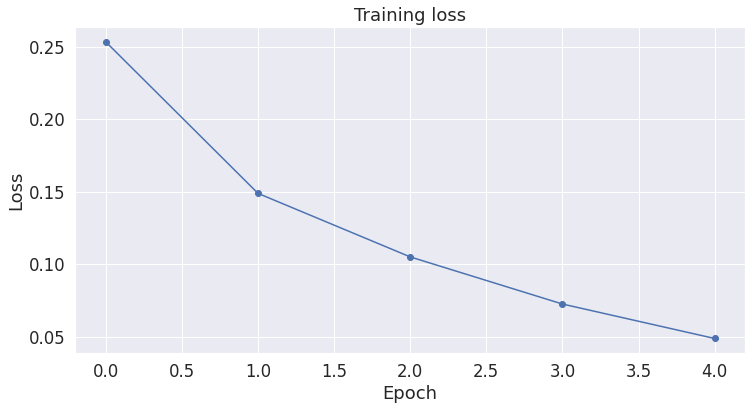

In [21]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [22]:
# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_data.shape[0]))

# Create sentence and label lists
sentences = test_data.clean_text.values
labels = test_data.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for sent in sentences:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        max_length = 512,
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 15,707



In [23]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions, true_labels = [], []
test_loss, test_accuracy = 0, 0
nb_test_steps, nb_test_examples = 0, 0

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # # Store predictions and true labels
  # predictions.append(logits)
  # true_labels.append(label_ids)

  # Calculate the accuracy for this batch of test sentences.
  tmp_test_accuracy = flat_accuracy(logits, label_ids)
  
  # Accumulate the total accuracy.
  test_accuracy += tmp_test_accuracy

  # Track the number of batches
  nb_test_steps += 1

# Report the final accuracy for this validation run.
print("Testing Accuracy: {0:.3f}".format(test_accuracy/nb_test_steps))
print('    DONE.')


Predicting labels for 15,707 test sentences...
Testing Accuracy: 0.922
    DONE.


In [24]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save_onion/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save_onion/


('./model_save_onion/vocab.txt',
 './model_save_onion/special_tokens_map.json',
 './model_save_onion/added_tokens.json')

In [29]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
  
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [0]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save_onion/ "/content/drive/My Drive/"

In [36]:
import keras
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from transformers import BertForSequenceClassification, BertTokenizer

# Load a trained model and vocabulary that you have fine-tuned
output_dir = '/content/drive/My Drive/model_save_onion/'
model = BertForSequenceClassification.from_pretrained(output_dir)
tokenizer = BertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
# model.to(device)


def predict(text, model):
  input_ids = []
  attention_masks = []
  encoded_text = tokenizer.encode(
                        text,                      
                        add_special_tokens = True,
                        max_length = 512
                   )
  input_ids.append(encoded_text)
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                            value=0, truncating="post", padding="post")
  
  
  attention_masks = []
  att_mask = [int(token_id > 0) for token_id in input_ids[0]]
  attention_masks.append(att_mask)

  inputs = torch.tensor(input_ids)
  attention_masks = torch.tensor(attention_masks)

  pred = model(inputs, token_type_ids=None, 
                      attention_mask=attention_masks)[0].argmax().item()
  if (pred == 0.0):
    print("Fake News")
  else:
    print("Real News")


predict('Netflix Now Worth More Than Disney', model)

Fake News
